<font size = 5>  A/B-тестирование </font>

## Цель исследования

Цель — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Задачи исследования:

- Оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, проверим:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import itertools
import requests
import re
import os
import math
from io import BytesIO

import scipy.stats as st
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

pd.set_option('display.float_format', '{:,.2f}'.format) #настройки pandas для отображения чисел без лишних запятых
pd.set_option("max_colwidth", 200) #настройки pandas для отображения строк полностью

## Описание данных и предобработка

Загрузим данные:

In [2]:
try:
    #маркетинговый календарь:
    final_ab_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv',
                                            parse_dates=['start_dt', 'finish_dt'])
    #новые пользователи
    final_ab_new_users  = pd.read_csv('/datasets/final_ab_new_users.csv', parse_dates = ['first_date'])
  
    #действия новых пользователей:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv', parse_dates = ['event_dt'])
    
    #таблица участников:
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

    
except:
    #маркетинговый календарь:
    final_ab_marketing_events  = pd.read_csv('D:/AB Test/final_ab_marketing_events.csv', 
                                             parse_dates=['start_dt', 'finish_dt'])
    #новые пользователи
    final_ab_new_users = pd.read_csv('D:/AB Test/final_ab_new_users.csv', parse_dates = ['first_date'])
    
    #действия новых пользователей:
    final_ab_events  = pd.read_csv('D:/AB Test/final_ab_events.csv', parse_dates = ['event_dt'])
    
    #таблица участников:   
    final_ab_participants = pd.read_csv('D:/AB Test/final_ab_participants.csv') 

In [3]:
def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('__([A-Z])', r'_\1', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

In [4]:
def preprocess_data(data, snake_case):
    if snake_case == True:
        snake_case_columns = []
        for column in data.columns:
            snake_case_columns.append(to_snake_case(column))
        data.columns = snake_case_columns
    
    print('\033[1m' + 'Info:' + '\033[0m')
    data.info()
    
    print()
    print('\033[1m' + 'Head:' + '\033[0m')
    display(data.head())
    
    print('\033[1m' + 'Shape:' + '\033[0m')
    display(data.shape)
    #display('Number of dublicated values')
    
    print('\033[1m' + 'Number of dublicated values:' + '\033[0m')
    display(data.duplicated().sum()) 
    
    print('\033[1m' + 'Number and Share of Missing values:' + '\033[0m')
    display(pd.concat([data.isna().sum(), data.isna().mean()], axis=1)\
            .rename(columns={0:'Количество пропусков', 1:'Доля'})\
            .style.format({'Количество пропусков':'{:.0f}', 'Доля':'{:.2%}'}))

### Календарь маркетинговых событий на 2020 год

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [5]:
preprocess_data(final_ab_marketing_events, False)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes

Head:


name                   regions   start_dt  \
0      Christmas&New Year Promo             EU, N.America 2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2        St. Patric's Day Promo             EU, N.America 2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4             4th of July Promo                 N.America 2020-07-04   

   finish_dt  
0 2021-01-03  
1 2020-02-16  
2 2020-03-19  
3 2020-04-19  
4 2020-07-11

Shape:


(14, 4)

Number of dublicated values:


0

Number and Share of Missing values:


В датасете нет пропущенных значений и дубликатов. Типы данных верные:

In [6]:
final_ab_marketing_events.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

### Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [7]:
preprocess_data(final_ab_new_users, False)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB

Head:


user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC
3  50734A22C0C63768 2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone

Shape:


(61733, 4)

Number of dublicated values:


0

Number and Share of Missing values:


В датасете нет дубликатов, пропущенных значений. Но также требуется привести столбец first_date к формату типа данных с датой.

In [8]:
final_ab_new_users.dtypes

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

In [9]:
final_ab_new_users['device'].value_counts().to_frame()

device
Android   27520
PC        15599
iPhone    12530
Mac        6084

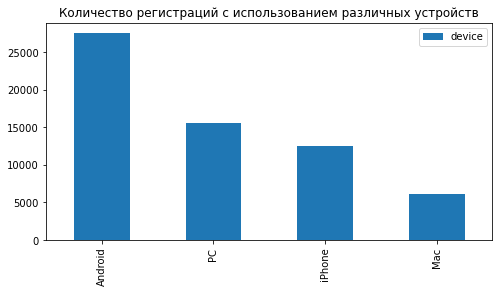

In [10]:
final_ab_new_users['device'].value_counts().to_frame().plot(kind='bar', figsize=(8,4))
plt.title('Количество регистраций с использованием различных устройств')
plt.show()

Есть данные о четырех типах устройств - Android, PC, iPhone, Mac. Больше всего действий совершено с использованием Android, меньше всего - с Mac.

### Действия новых пользователей

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [11]:
preprocess_data(final_ab_events, False)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB

Head:


user_id            event_dt event_name  details
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457 2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99

Shape:


(440317, 4)

Number of dublicated values:


0

Number and Share of Missing values:


Поменяем тип данных в необходимых колонках:

In [12]:
final_ab_events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

Обнаружено 85% пропущенных значений в столбце details 

In [13]:
final_ab_events.query('details.isnull() == True', engine='python').head()

user_id            event_dt    event_name  details
62740  2E1BF1D4C37EA01F 2020-12-07 09:05:47  product_cart      NaN
62741  50734A22C0C63768 2020-12-07 13:24:03  product_cart      NaN
62742  5EB159DA9DC94DBA 2020-12-07 22:54:02  product_cart      NaN
62743  084A22B980BA8169 2020-12-07 15:25:55  product_cart      NaN
62744  0FC21E6F8FAA8DEC 2020-12-07 06:56:27  product_cart      NaN

In [14]:
final_ab_events.groupby('event_name').agg('count')

user_id  event_dt  details
event_name                              
login          189552    189552        0
product_cart    62462     62462        0
product_page   125563    125563        0
purchase        62740     62740    62740

В столбце details указана сумма покупки (на стадии purchase), пропущенные значения в этом столбце присутствуют на других стадиях воронки (login, product_cart, product_page), - так и должно быть, т.е. пропуски не случайны. Обрабатывать или удалять их не будем.

### Таблица участников тестов

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [15]:
preprocess_data(final_ab_participants, False)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Head:


user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

Shape:


(18268, 3)

Number of dublicated values:


0

Number and Share of Missing values:


В этом датасете не требуется дополнительная обработка.

## Функции для проверки гипотез о равенстве долей

In [16]:
def check_hypothesis(successes1, successes2, trials1, trials2):

    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    #print(p1)
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(
        p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2)
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value

In [17]:
def final_result(p_value):
    alpha = .05 # критический уровень статистической значимости
    
    if (p_value < alpha):
        return "Отвергаем нулевую гипотезу - между долями есть статистически значимая разница"
    else:
        return "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными" 

## Оценка корректности проведения теста

### Соответствие данных требованиям технического задания

Название теста: **recommender_system_test**.
* группы: А — контрольная, B — новая платёжная воронка

*Назначение теста*: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

Сведения о тесте содержатся в датасете final_ab_participants.

In [18]:
final_ab_participants.head()

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

In [19]:
final_ab_participants_table = pd.pivot_table(final_ab_participants,
                                             values='user_id',
                                             index='ab_test',
                                             columns='group',
                                             aggfunc = 'nunique') #количество уникальных пользователей
                                             
final_ab_participants_table

group                       A     B
ab_test                            
interface_eu_test        5831  5736
recommender_system_test  3824  2877

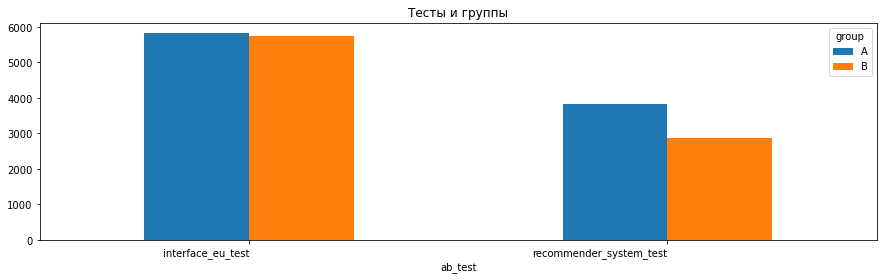

In [20]:
final_ab_participants_table.plot(kind='bar', figsize=(15,4))
plt.title('Тесты и группы')
plt.xticks(rotation=360, ha='right')
plt.show()

Есть данные о тесте recommender_system_test, в группе А - 3824 пользователя, в группе В - 2877 пользователей.

Ожидаемое количество участников теста: 6000. Фактическое:

In [21]:
final_ab_participants_table['A'][1] + final_ab_participants_table['B'][1]

6701

### Время проведения теста

Согласно ТЗ:
- дата запуска: **2020-12-07**;
- дата остановки набора новых пользователей: **2020-12-21**;
- дата остановки: **2021-01-04**;

In [22]:
final_ab_events.head()

user_id            event_dt event_name  details
0  E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457 2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99

In [23]:
final_ab_events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [24]:
final_ab_events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Действия пользователей зафиксированы с **7 декабря 2020 г.** по **30 декабря 2020 г.**

Здесь обратим внимание на то, что данные неполные, так как планировалась остановка теста 4 января 2021 г. Стоит проверить, будет ли для части пользователей соблюдаться требование о 14-дневном периоде с момента регистрации. В п. 5.3.4 "Горизонт анализа" часть действий пользователей будет удалена для соответствия требованию о периоде с момента регистрации.

Теперь посмотрим на таблицу с новыми пользователями:

In [25]:
final_ab_new_users.head()

user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC
3  50734A22C0C63768 2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone

In [26]:
final_ab_new_users.pivot_table(index='first_date', columns = 'region', aggfunc = 'count', values='user_id')

region      APAC  CIS    EU  N.America
first_date                            
2020-12-07   255  293  4205        842
2020-12-08   165  166  2415        493
2020-12-09    91   94  1608        308
2020-12-10   159  138  2352        427
2020-12-11   115  122  1804        349
2020-12-12   199  199  2984        581
2020-12-13   231  244  3511        705
2020-12-14   298  290  4242        824
2020-12-15   179  162  2283        419
2020-12-16   116   98  1582        314
2020-12-17   179  135  2273        461
2020-12-18   167  149  2546        503
2020-12-19   204  204  2657        552
2020-12-20   193  236  3228        631
2020-12-21   332  370  4650        938
2020-12-22   158  165  2292        468
2020-12-23   112   90  1638        340

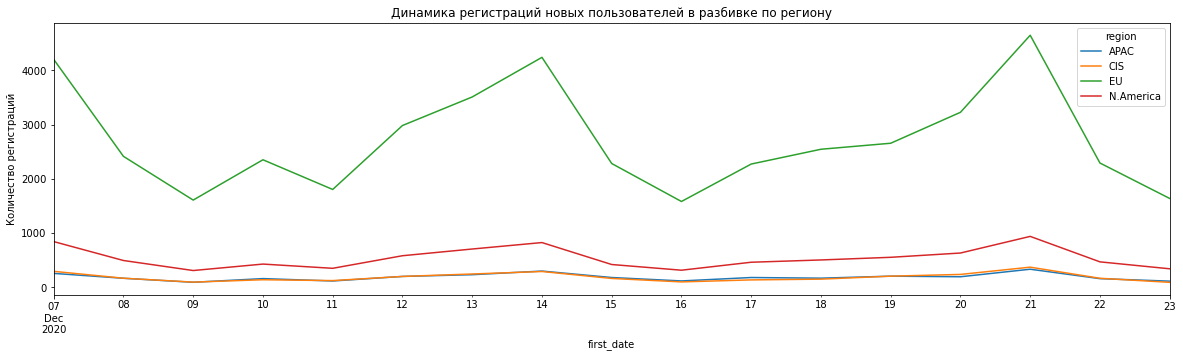

In [27]:
final_ab_new_users.pivot_table(index='first_date', 
                               columns = 'region', aggfunc = 'count', values='user_id').plot(figsize=(20,5))
plt.ylabel('Количество регистраций')
plt.title('Динамика регистраций новых пользователей в разбивке по региону')
plt.show()

Динамика регистраций в разбивке по региону показывает, что больше всего регистрируется пользователей из Европы, далее следует Северная Америка и остальные регионы. 

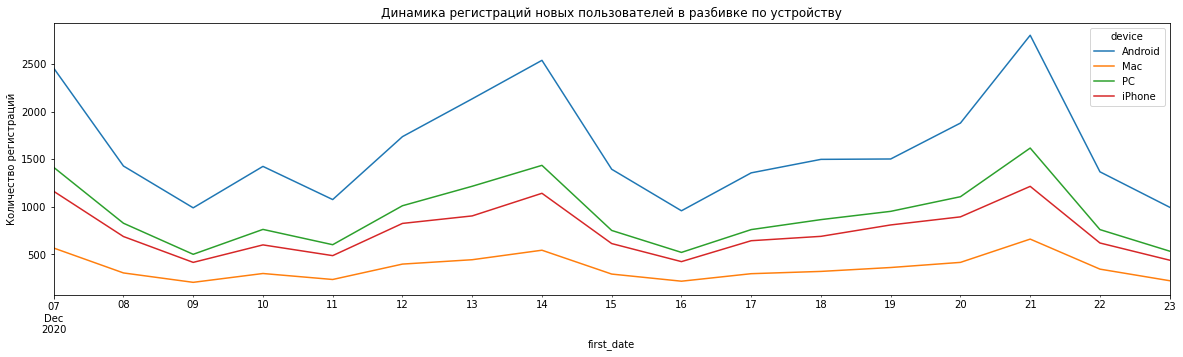

In [28]:
final_ab_new_users.pivot_table(index='first_date', 
                               columns = 'device', aggfunc = 'count', values='user_id').plot(figsize=(20,5))
plt.ylabel('Количество регистраций')
plt.title('Динамика регистраций новых пользователей в разбивке по устройству')
plt.show()

Динамика регистраций в разбивке по устройству показывает популярность Андроид, остальные устройства менее популярны.

In [29]:
final_ab_new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [30]:
final_ab_new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

В датасете есть данные о новых пользователях до 23 декабря 2020г., а согласно ТЗ сбор сведений о новых пользователей должен заканчиваться 21 декабря.

In [31]:
final_ab_new_users = final_ab_new_users[final_ab_new_users['first_date'] <= '2020-12-21']

Срез по дате регистрации произведен.

Еще сверим сроки с календарем маркетинговых событий:

In [32]:
fig = px.timeline(final_ab_marketing_events, x_start="start_dt", x_end="finish_dt", y="name", color="regions",
                 title = 'Календарь маркетинговых событий на 2020 год')
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

Построена визуализация с использованием plotly.

In [33]:
final_ab_marketing_events.sort_values(by='start_dt')

name                   regions   start_dt  \
6             Chinese New Year Promo                      APAC 2020-01-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
8    International Women's Day Promo             EU, CIS, APAC 2020-03-08   
2             St. Patric's Day Promo             EU, N.America 2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
9    Victory Day CIS (May 9th) Event                       CIS 2020-05-09   
11     Dragon Boat Festival Giveaway                      APAC 2020-06-25   
4                  4th of July Promo                 N.America 2020-07-04   
13             Chinese Moon Festival                      APAC 2020-10-01   
12           Single's Day Gift Promo                      APAC 2020-11-11   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
0           Christmas&New Year Promo             EU, N.America 2020-12-25   
10         CIS New Year Gift Lottery                       CIS 2020-12-30   

    finish_dt  
6  2020-02-07  
1  2020-02-16  
8  2020-03-10  
2  2020-03-19  
3  2020-04-19  
7  2020-05-03  
9  2020-05-11  
11 2020-07-01  
4  2020-07-11  
13 2020-10-07  
12 2020-11-12  
5  2020-12-01  
0  2021-01-03  
10 2021-01-07

Получается, что **64 283 событий** происходило в период с 25 декабря по 30 декабря, в это время проходили две маркетинговых акции.

In [34]:
final_ab_events[final_ab_events['event_dt'] >= '2020-12-25']

user_id            event_dt event_name  details
53604   E1BDDCE0DAFA2679 2020-12-25 08:26:03   purchase   499.99
53605   7FCD34F47C13A9AC 2020-12-25 13:26:31   purchase    99.99
53606   649ECF69EC552A56 2020-12-25 21:07:03   purchase    99.99
53607   2012540DBF0BFD76 2020-12-25 14:07:55   purchase     4.99
53608   D8FBEA060A86A58D 2020-12-25 03:10:30   purchase     9.99
...                  ...                 ...        ...      ...
440312  245E85F65C358E08 2020-12-30 19:35:55      login      NaN
440313  9385A108F5A0A7A7 2020-12-30 10:54:15      login      NaN
440314  DB650B7559AC6EAC 2020-12-30 10:59:09      login      NaN
440315  F80C9BDDEA02E53C 2020-12-30 09:53:39      login      NaN
440316  7AEC61159B672CC5 2020-12-30 11:36:13      login      NaN

[64283 rows x 4 columns]

Видим, что есть данные за период, в течение которых проходили маркетинговые акции.

Не стоит удалять данные, в течение которых проходили маркетинговые акции. Если мы фильтруем таким образом, то мы уменьшаем количество дней, за которые происходит набор польователей в тест. А мы помним про требование ТЗ – учитывать события в период 14 дней после регистрации. Впредь мы можем рекомендовать проводить тест во время отсутствия маркетинговых акций для рассматриваемой аудитории.

В декабре 2020 г. начали проводится два маркетинговых мероприятия - Christmas&New Year Promo (c 2020-12-25), CIS New Year Gift Lottery (c 2020-12-30). Их проведение совпадает с нашим тестом!

### Аудитория теста

Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

#### Проверка пересечений с конкурирующим тестом

Разобьем данные об участниках на две таблицы - из одного и другого теста.

In [35]:
final_ab_participants.head()

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

In [36]:
recommender = final_ab_participants.query('ab_test == "recommender_system_test"')

In [37]:
len(recommender)

6701

В тесте recommender_system_test принимает участие 6701 пользователей.

In [38]:
interface = final_ab_participants.query('ab_test == "interface_eu_test"')

In [39]:
len(interface)

11567

В тесте interface_eu_test принимает участие 11 567 пользователей.

Создадим список с пересекающимися значениями:

In [40]:
user_list = []
for i in recommender['user_id']:
    for j in interface['user_id']:
        if i == j:
            user_list.append(i)

In [41]:
len(user_list)

1602

Получилось, что в тестах пересекается 1602 значения. Далее из списка recommender нужно удалить пользователей, которые попали в список user_list.

In [42]:
len(recommender)

6701

In [43]:
for id in recommender['user_id']:
    for value in user_list:
        if id == value:
            recommender = recommender.drop(recommender[recommender.user_id == id].index)

Данное решение позволит удалить пользователей, попавших в оба теста, так как второй тест мог повлиять на изучаемую метрику.

In [44]:
len(recommender)

5099

In [45]:
recommender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5099 non-null   object
 1   group    5099 non-null   object
 2   ab_test  5099 non-null   object
dtypes: object(3)
memory usage: 159.3+ KB


In [46]:
recommender.head()

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test
5  4FF2998A348C484F     A  recommender_system_test
6  7473E0943673C09E     A  recommender_system_test

#### Проверка пересечений между группами теста

По итогам видим, что в группе A - 2902 пользователей, в группе В - 2196 пользователя.

In [47]:
recommender.groupby('group').agg({'user_id': 'count'})

user_id
group         
A         2903
B         2196

In [48]:
recommender.groupby('group').agg({'user_id': 'nunique'})

user_id
group         
A         2903
B         2196

In [49]:
recommender_a = recommender.query('group == "A"')
recommender_b = recommender.query('group == "B"')

In [50]:
len(recommender_a)

2903

In [51]:
len(recommender_b)

2196

In [52]:
user_list = []
for i in recommender_a['user_id']:
    for j in recommender_b['user_id']:
        if i == j:
            user_list.append(value)

In [53]:
len(user_list)

0

Пересечений нет.

Проверка на пересечение успешно проведена.

#### Исследование новых пользователей

Посмотрим на таблицу с новыми пользователями.

In [54]:
final_ab_new_users.head()

user_id first_date     region   device
0  D72A72121175D8BE 2020-12-07         EU       PC
1  F1C668619DFE6E65 2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F 2020-12-07         EU       PC
3  50734A22C0C63768 2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone

In [55]:
final_ab_new_users.shape

(56470, 4)

В таблице данные о 56 470 пользователях, которые были зарегистированы в период проведения теста.

In [56]:
test_data_by_region = pd.pivot_table(final_ab_new_users, 
               values='user_id', 
               index='region', 
               #columns='group', 
               aggfunc='nunique')
test_data_by_region.head()

user_id
region            
APAC          2883
CIS           2900
EU           42340
N.America     8347

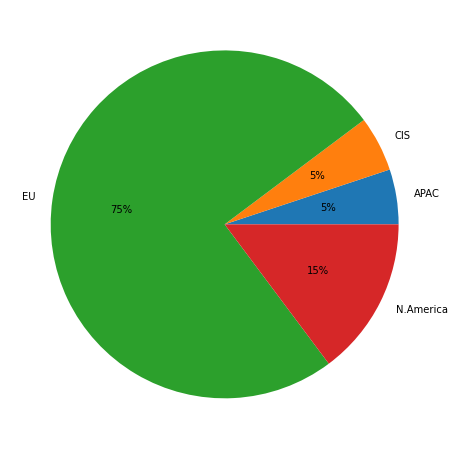

In [57]:
plt.figure(figsize=(8,8))
labels = ['APAC', 'CIS', 'EU', 'N.America']
plt.pie(test_data_by_region['user_id'], autopct='%.0f%%', 
        labels = labels, 
        #colors = colors
       )
plt.show()

Нам нужно проверить условие - аудитория: 15% новых пользователей из региона EU.

In [58]:
final_ab_new_users.query('region == "EU"')

user_id first_date region   device
0      D72A72121175D8BE 2020-12-07     EU       PC
2      2E1BF1D4C37EA01F 2020-12-07     EU       PC
3      50734A22C0C63768 2020-12-07     EU   iPhone
7      8942E64218C9A1ED 2020-12-07     EU       PC
9      FFCEA1179C253104 2020-12-07     EU  Android
...                 ...        ...    ...      ...
61728  1DB53B933257165D 2020-12-20     EU  Android
61729  538643EB4527ED03 2020-12-20     EU      Mac
61730  7ADEE837D5D8CBBD 2020-12-20     EU       PC
61731  1C7D23927835213F 2020-12-20     EU   iPhone
61732  8F04273BB2860229 2020-12-20     EU  Android

[42340 rows x 4 columns]

В итоге 42340 новых пользователей из региона EU.

In [59]:
new_users_eu = recommender.merge(final_ab_new_users, on = ['user_id'], how = 'left') 

In [60]:
new_users_eu.head()

user_id group                  ab_test first_date region  device
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU      PC
1  A7A3664BD6242119     A  recommender_system_test 2020-12-20     EU  iPhone
2  482F14783456D21B     B  recommender_system_test 2020-12-14     EU      PC
3  4FF2998A348C484F     A  recommender_system_test 2020-12-20     EU     Mac
4  7473E0943673C09E     A  recommender_system_test 2020-12-16     EU  iPhone

In [61]:
new_users_by_region = new_users_eu.groupby('region').agg({'user_id': 'nunique'})
new_users_by_region

user_id
region            
APAC            72
CIS             55
EU            4749
N.America      223

In [62]:
new_users_by_region.loc['EU', 'user_id']

4749

Посчитаем, сколько должно быть пользователей из региона EU:

In [63]:
len(final_ab_new_users.query('region == "EU"'))*15/100

6351.0

В таблице recommender должно быть 6351 пользователей, а у нас получилось 5099 с учетом удаления пересекающихся значений (меньше, чем нужно по условию).

In [64]:
len(recommender)

5099

Не все они из EU. Из EU только 4749 пользователя.

In [65]:
new_users_by_region.loc['EU', 'user_id'] * 100 / len(final_ab_new_users.query('region == "EU"'))

11.216343882853094

Вывод: аудитория - меньше, чем 15% новых пользователей из региона EU. А именно **11.21%** после очистки от пересекающихся значений.

Однако это еще не значит, что отклонение существенное.

In [66]:
new_users_by_region.loc['APAC', 'user_id'] * 100 / len(final_ab_new_users.query('region == "EU"'))

0.17005196032120926

В эксперимент попало еще 0.17% пользователей из APAC.

In [67]:
new_users_by_region.loc['CIS', 'user_id'] * 100 / len(final_ab_new_users.query('region == "EU"'))

0.12990080302314597

В эксперимент попало еще 0.13%  пользователей из CIS.

In [68]:
new_users_by_region.loc['N.America', 'user_id'] * 100 / len(final_ab_new_users.query('region == "EU"'))

0.5266887104393009

В эксперимент попало еще 0.52% пользователей из N.America.

In [69]:
new_users_eu.groupby('group').agg('nunique')

user_id  ab_test  first_date  region  device
group                                              
A         2903        1          15       4       4
B         2196        1          15       4       4

In [70]:
data_by_region = pd.pivot_table(new_users_eu, 
               values='user_id', 
               index='region', 
               columns='group', 
               aggfunc='nunique')
data_by_region.head()

group         A     B
region               
APAC         37    35
CIS          25    30
EU         2713  2036
N.America   128    95

In [71]:
labels = ['APAC', 'CIS', 'EU', 'N.America']
colors = sns.color_palette('pastel')

fig = plt.figure(figsize=(25,10), dpi=800)

ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie(data_by_region['A'], autopct='%.0f%%', 
        labels = labels, 
        colors = colors)
plt.title('Доли регионов в группе А', fontsize = 20)

#next one
ax1 = plt.subplot2grid((1, 2), (0, 1))
plt.pie(data_by_region['B'], autopct='%.0f%%', 
        labels = labels, 
        colors = colors)
plt.title('Доли регионов в группе В', fontsize = 20)

plt.show()

Из графиков выше видим, что в группе А и В по 93% приходится на европейский регион.

**Вывод:** аудитория - меньше, чем 15% новых пользователей из региона EU. А именно **11.21%** после очистки от пересекающихся значений. Участниками теста также выступили пользователи из других регионов, хотя в ТЗ хотели только 15% новых пользователей EU.

Проведем z-тест и  проверить насколько эта разница статистически значима.

In [72]:
trials1 = len(final_ab_new_users.query('region == "EU"'))
trials1

42340

In [73]:
trials2 = trials1
trials2

42340

In [74]:
successes1 = len(final_ab_new_users.query('region == "EU"'))*15/100 #сколько должно быть пользователей
successes1

6351.0

In [75]:
successes2 = new_users_by_region.loc['EU', 'user_id'] #сколько пользователей фактически
successes2

4749

In [76]:
p_value = check_hypothesis(successes1, successes2, trials1, trials2)
p_value

0.0

In [77]:
final_result(p_value)

'Отвергаем нулевую гипотезу - между долями есть статистически значимая разница'

Все таки в результате z-теста получен результат о статистической значимости разницы, значит результаты А/В теста могут быть искажены (доверять в полной мере скорее всего нельзя)

#### Горизонт анализа

Перед тем как анализировать распределение стоит изучить ТЗ, в котором сказано про 2-недельный период. Суть в том, что нам важно, чтобы с момента регистрации до момента совершения действия прошло не более двух недель. Для каждого пользователя мы находим дату регистрации и смотрим, чтобы события были совершены в течение 2 недель с момента регистрации.

При расчёте метрик учитывают:
* Момент анализа. Это момент времени, в который смотрим на данные. 
* Горизонт анализа. Максимальный лайфтайм, который можно проанализировать.

Момент анализа ограничивает возможный горизонт анализа данных. Важно следить за тем, чтобы в отчёты не попадали пользователи, которые не успели «дожить» до выбранного горизонта.

**Согласно ТЗ, мы рассматриваем действия пользователей за 14 дней с момента регистрации.** То есть максимальный лайфтайм - 14.

In [78]:
final_ab_events['event_dt'].max() - final_ab_new_users['first_date'].max()

Timedelta('9 days 23:36:33')

In [79]:
final_ab_events['event_dt'].max() - final_ab_new_users['first_date'].min() #здесь мы не видим какой пользователь

Timedelta('23 days 23:36:33')

**По пользователям, которые зарегистрировались 7 декабря, мы должны рассматривать действия в течение 14 дней, т.е. до 21 декабря, а действия с 22 по 30 декабря нужно удалить. И аналогично по пользователям с моментом регистрации до 16 декабря (30-14).**

Для удобства дальнейшего анализа объединим таблицы и отфильтруем данные:

Сначала объединим таблицу recommender, в которой находятся участники теста (их нужно всех сохранить) и таблицу с действиями. Возможно, у некоторых участников действий не будет.

In [80]:
test_data = recommender.merge(final_ab_events, on = ['user_id'], how = 'left') 

In [81]:
del test_data['ab_test']

Затем добавим таблицу с новыми пользователями (войдут только те пользователи, которые есть в датафрейме test_data):

In [82]:
test_data_users = test_data.merge(final_ab_new_users, on = ['user_id'], how = 'left') 

In [83]:
test_data_users.head()

user_id group            event_dt    event_name  details  \
0  D1ABA3E2887B6A73     A 2020-12-07 14:43:27      purchase    99.99   
1  D1ABA3E2887B6A73     A 2020-12-25 00:04:56      purchase     4.99   
2  D1ABA3E2887B6A73     A 2020-12-07 14:43:29  product_cart      NaN   
3  D1ABA3E2887B6A73     A 2020-12-25 00:04:57  product_cart      NaN   
4  D1ABA3E2887B6A73     A 2020-12-07 14:43:27  product_page      NaN   

  first_date region device  
0 2020-12-07     EU     PC  
1 2020-12-07     EU     PC  
2 2020-12-07     EU     PC  
3 2020-12-07     EU     PC  
4 2020-12-07     EU     PC

In [84]:
test_data_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   event_dt    18804 non-null  datetime64[ns]
 3   event_name  18804 non-null  object        
 4   details     2483 non-null   float64       
 5   first_date  21115 non-null  datetime64[ns]
 6   region      21115 non-null  object        
 7   device      21115 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 1.4+ MB


In [85]:
test_data_users_size = test_data_users.shape[0]
test_data_users_size

21115

В таблице 21115 записей.

In [86]:
test_data_users.query('event_name.isnull() == True', engine='python').head()

user_id group event_dt event_name  details first_date region  \
14  482F14783456D21B     B      NaT        NaN      NaN 2020-12-14     EU   
41  057AB296296C7FC0     B      NaT        NaN      NaN 2020-12-17     EU   
42  E9FA12FAE3F5769C     B      NaT        NaN      NaN 2020-12-14     EU   
43  FDD0A1016549D707     A      NaT        NaN      NaN 2020-12-13     EU   
44  547E99A7BDB0FCE9     A      NaT        NaN      NaN 2020-12-12     EU   

     device  
14       PC  
41   iPhone  
42  Android  
43       PC  
44   iPhone

Посчитаем разницу между датой совершения события и датой регистрации, она должна быть не больше 14 дней:

In [87]:
test_data_users['horizon'] = test_data_users['event_dt'] - test_data_users['first_date']

In [88]:
test_data_users.head()

user_id group            event_dt    event_name  details  \
0  D1ABA3E2887B6A73     A 2020-12-07 14:43:27      purchase    99.99   
1  D1ABA3E2887B6A73     A 2020-12-25 00:04:56      purchase     4.99   
2  D1ABA3E2887B6A73     A 2020-12-07 14:43:29  product_cart      NaN   
3  D1ABA3E2887B6A73     A 2020-12-25 00:04:57  product_cart      NaN   
4  D1ABA3E2887B6A73     A 2020-12-07 14:43:27  product_page      NaN   

  first_date region device          horizon  
0 2020-12-07     EU     PC  0 days 14:43:27  
1 2020-12-07     EU     PC 18 days 00:04:56  
2 2020-12-07     EU     PC  0 days 14:43:29  
3 2020-12-07     EU     PC 18 days 00:04:57  
4 2020-12-07     EU     PC  0 days 14:43:27

In [89]:
test_data_users['horizon'].min()

Timedelta('0 days 00:00:04')

In [90]:
test_data_users['horizon'].max()

Timedelta('23 days 06:42:52')

Видим, что максимальное значение равно 23 дня, поэтому обрежем данные. Сначала установим максимально допустимое значение переменной horizon:

In [91]:
horizon = timedelta(days = 14)
horizon

datetime.timedelta(days=14)

In [92]:
for index, row in test_data_users.iterrows():
    if row['horizon'] > horizon:
        test_data_users.drop(index, inplace=True)

In [93]:
test_data_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20465 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   user_id     20465 non-null  object         
 1   group       20465 non-null  object         
 2   event_dt    18154 non-null  datetime64[ns] 
 3   event_name  18154 non-null  object         
 4   details     2406 non-null   float64        
 5   first_date  20465 non-null  datetime64[ns] 
 6   region      20465 non-null  object         
 7   device      20465 non-null  object         
 8   horizon     18154 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 1.6+ MB


In [94]:
test_data_users_size - test_data_users.shape[0]

650

Удалено 650 строк.

In [95]:
test_data_users

user_id group            event_dt    event_name  details  \
0      D1ABA3E2887B6A73     A 2020-12-07 14:43:27      purchase    99.99   
2      D1ABA3E2887B6A73     A 2020-12-07 14:43:29  product_cart      NaN   
4      D1ABA3E2887B6A73     A 2020-12-07 14:43:27  product_page      NaN   
6      D1ABA3E2887B6A73     A 2020-12-07 14:43:27         login      NaN   
8      A7A3664BD6242119     A 2020-12-20 15:46:06  product_page      NaN   
...                 ...   ...                 ...           ...      ...   
21110  6715343AFBA285AE     B 2020-12-07 10:12:15         login      NaN   
21111  6715343AFBA285AE     B 2020-12-08 22:51:16         login      NaN   
21112  6715343AFBA285AE     B 2020-12-09 02:28:03         login      NaN   
21113  6715343AFBA285AE     B 2020-12-10 22:55:14         login      NaN   
21114  6715343AFBA285AE     B 2020-12-14 12:40:41         login      NaN   

      first_date region   device         horizon  
0     2020-12-07     EU       PC 0 days 14:43:27  
2     2020-12-07     EU       PC 0 days 14:43:29  
4     2020-12-07     EU       PC 0 days 14:43:27  
6     2020-12-07     EU       PC 0 days 14:43:27  
8     2020-12-20     EU   iPhone 0 days 15:46:06  
...          ...    ...      ...             ...  
21110 2020-12-07    CIS  Android 0 days 10:12:15  
21111 2020-12-07    CIS  Android 1 days 22:51:16  
21112 2020-12-07    CIS  Android 2 days 02:28:03  
21113 2020-12-07    CIS  Android 3 days 22:55:14  
21114 2020-12-07    CIS  Android 7 days 12:40:41  

[20465 rows x 9 columns]

In [96]:
wrong_horizon_events = []
for index, row in test_data_users.iterrows():
    if row['horizon'] > horizon:
        wrong_horizon_events.append(index)
len(wrong_horizon_events)        

0

Видим, что значений, которые не соответствуют условию, не осталось. Горизонт анализа учтен.

## Исследовательский анализ данных

### Количество событий на пользователя

Исследуем количество событий на пользователя и их распределение в выборках.

In [97]:
test_data = test_data_users

В некоторых столбцах получились пропущенные значения - это значит, что некоторые участники теста не совершали никаких действий.

In [98]:
test_data.groupby('group').agg('nunique')

user_id  event_dt  event_name  details  first_date  region  device  \
group                                                                       
A         2903      9515           4        4          15       4       4   
B         2196      2668           4        4          15       4       4   

       horizon  
group           
A         9463  
B         2666

Осталось такое же количество уникальных пользователей: из группы A *2903 уникальных пользователей* совершили 9781 событий. По группе B *2196 уникальных пользователей* совершили 2839 событий.

In [99]:
test_data.pivot_table(index = 'group', 
                      columns = 'event_name',
                      values = 'user_id', 
                      aggfunc=['count', 'nunique'])

count                                    nunique               \
event_name login product_cart product_page purchase   login product_cart   
group                                                                      
A           6345         1940         4126     1929    2082          631   
B           1849          506          982      477     705          195   

                                  
event_name product_page purchase  
group                             
A                  1360      652  
B                   397      198

Здесь можно сравнить сколько всего событий было совершено, и сколько событий было совершено уникальными пльзователями.

Например, в группе А действие логин было совершено 6525 раз, его совершало 2082 уникальных пользователей. 

Сгруппируем данные по группам и посчитаем количество событий на пользователя:

In [100]:
test_data_pivoted = pd.pivot_table(test_data, 
               values='event_dt', 
               index='user_id', 
               columns='group', 
               aggfunc='count')
test_data_pivoted.head()

group                A   B
user_id                   
000ABE35EE11412F  0.00 NaN
0010A1C096941592 12.00 NaN
001C05E87D336C59  0.00 NaN
003DF44D7589BBD4 15.00 NaN
00505E15A9D81546  5.00 NaN

In [101]:
test_data_pivoted['A'].mean()

4.939717533585946

In [102]:
test_data_pivoted['B'].mean()

1.7367941712204007

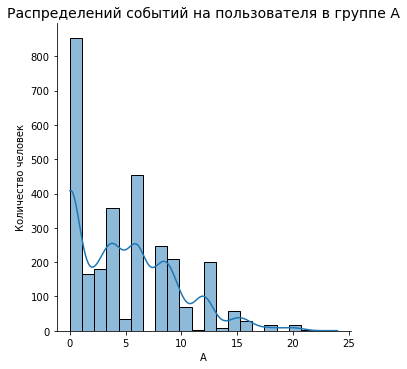

In [103]:
sns.displot(test_data_pivoted, x='A', kde=True)
plt.title('Распределений событий на пользователя в группе A', fontsize=14)
plt.ylabel('Количество человек')
plt.show()

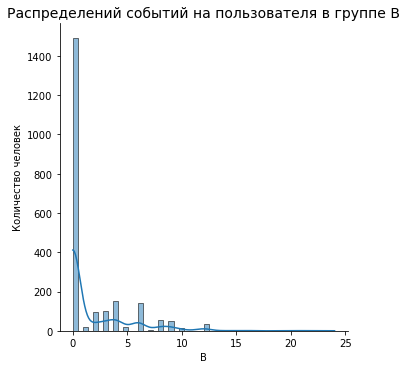

In [104]:
sns.displot(test_data_pivoted, x='B', kde=True)
plt.title('Распределений событий на пользователя в группе В', fontsize=14)
plt.ylabel('Количество человек')
plt.show()

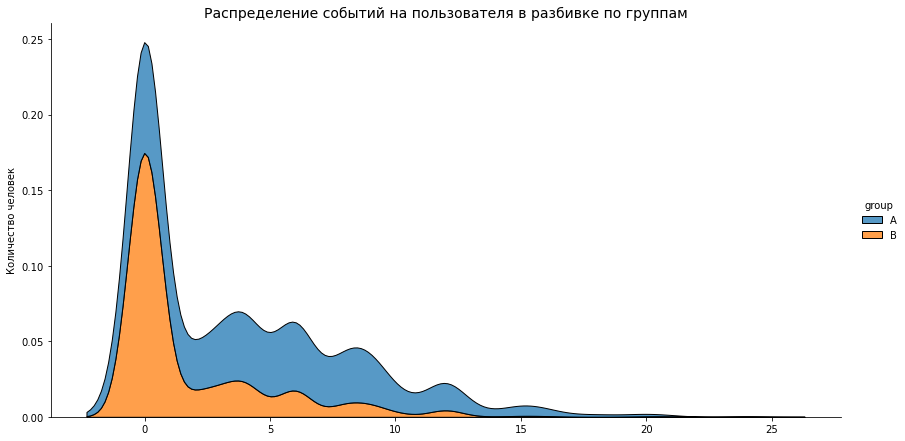

In [105]:
sns.displot(data=test_data_pivoted,
                     #x=column, 
                     kind="kde", 
                     height=6,
                     aspect=2,
                     #hue="products",
                     multiple="stack",
                     fill = True
                    )

plt.title('Распределение событий на пользователя в разбивке по группам', fontsize=14)
plt.ylabel('Количество человек')
plt.show()

Распределение похоже на распределение Пуассона.

В группе А пользователи совершали в среднем 5 событий, а в группе В - 1-2 события. Пик приходится на значение 0 - многие пользователи из обеих групп не совершали никаких действий. 

### Распределение для тех, кто совершал событие

Отдельно рассмотрим распределение для тех, кто совершал событие:

In [106]:
active_users_events = test_data_pivoted.query('A != 0 &  B != 0')
active_users_events

group                A    B
user_id                    
0010A1C096941592 12.00  NaN
003DF44D7589BBD4 15.00  NaN
00505E15A9D81546  5.00  NaN
005E096DBD379BCF   NaN 4.00
006E3E4E232CE760  6.00  NaN
...                ...  ...
FF5A1CD38F5DD996 10.00  NaN
FF5B24BCE4387F86  9.00  NaN
FF825C1D791989B5  8.00  NaN
FF8CF7057415EB29   NaN 4.00
FFAE9489C76F352B  6.00  NaN

[2788 rows x 2 columns]

In [107]:
active_users_events['A'].mean()

6.887608069164265

In [108]:
active_users_events['B'].mean()

5.402266288951841

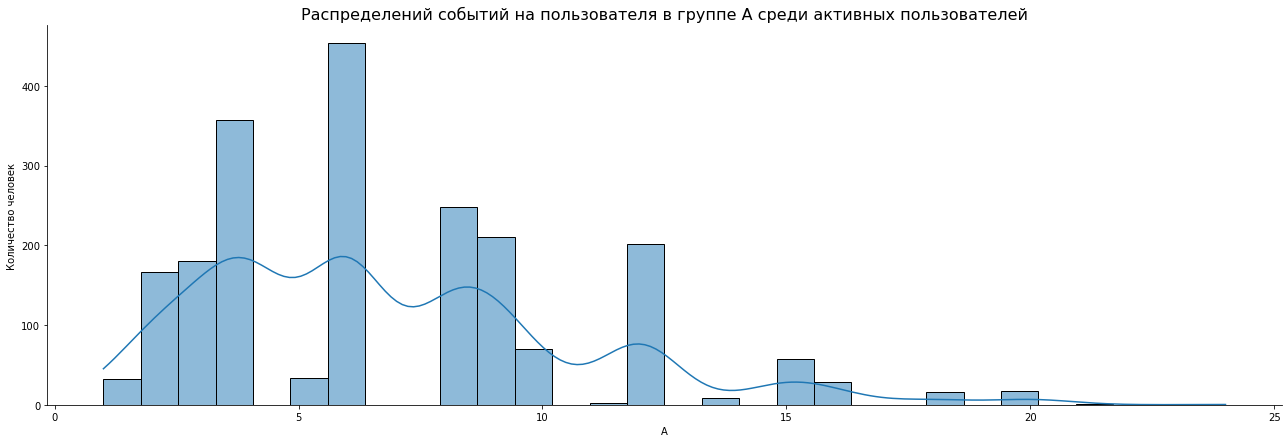

In [109]:
sns.displot(active_users_events, x='A', kde=True, height=6, aspect=3)
plt.title('Распределений событий на пользователя в группе A среди активных пользователей', fontsize=16)
plt.ylabel('Количество человек')
plt.show()

Среди активных пользователей среднее количество событий - 6.8. Из гистограмы видим, что многие пользователи совершают 6 действий. Большее количество действий совершает меньше пользователей.

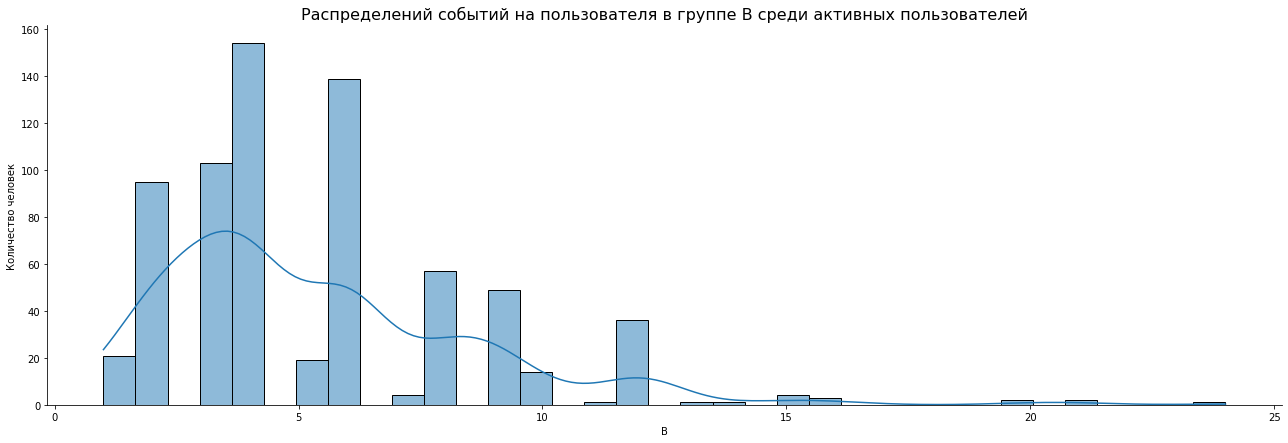

In [110]:
sns.displot(active_users_events, x='B', kde=True, height=6, aspect=3)
plt.title('Распределений событий на пользователя в группе B среди активных пользователей', fontsize=16)
plt.ylabel('Количество человек')
plt.show()

В группе В среди активных пользователей среднее значение количества событий - 5.4.  

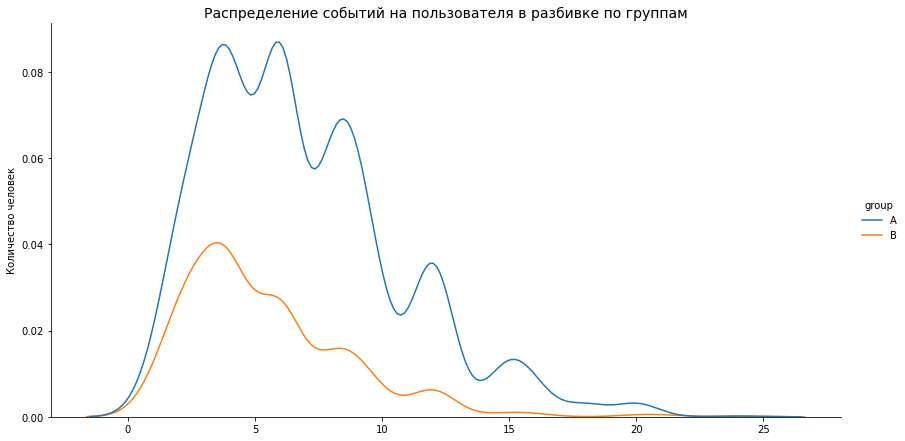

In [111]:
sns.displot(data=active_users_events,
                     #x=column, 
                     kind="kde", 
                     height=6,
                     aspect=2,
                     #hue="products",
                     #multiple="stack",
                     #fill = True
                    )

plt.title('Распределение событий на пользователя в разбивке по группам', fontsize=14)
plt.ylabel('Количество человек')
plt.show()

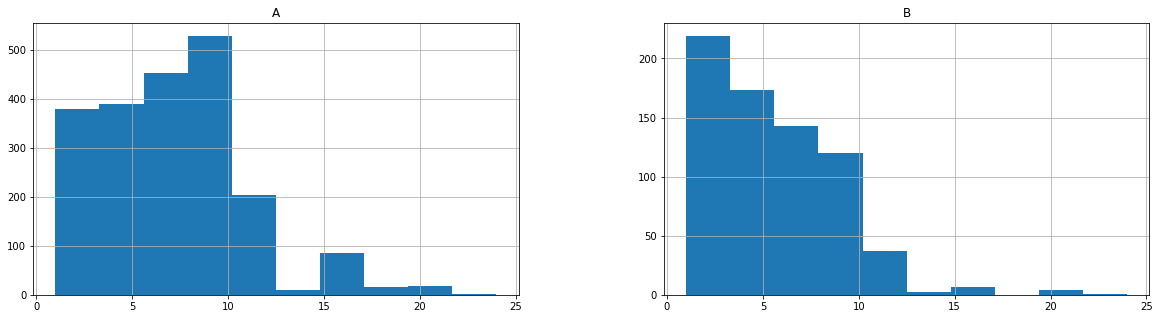

In [112]:
active_users_events.hist(figsize=(20,5))
plt.show()

В группе А событий больше, чем в группе В. 

### Количество событий на пользователя в разбивке по типу события

Рассмотрим еще количество событий на пользователя в разбивке по типу события.

In [113]:
test_data_a = test_data.query('group == "A"')

In [114]:
test_data_b = test_data.query('group == "B"')

In [115]:
events_by_name_a = pd.pivot_table(test_data_a, 
               values='event_dt', 
               index='user_id', 
               columns='event_name', 
               aggfunc='count')
events_by_name_a.head()

event_name        login  product_cart  product_page  purchase
user_id                                                      
0010A1C096941592   4.00           NaN          4.00      4.00
003DF44D7589BBD4   5.00          5.00          5.00       NaN
00505E15A9D81546   5.00           NaN           NaN       NaN
006E3E4E232CE760   3.00           NaN          3.00       NaN
00A52DCF85F1BE03   2.00           NaN           NaN       NaN

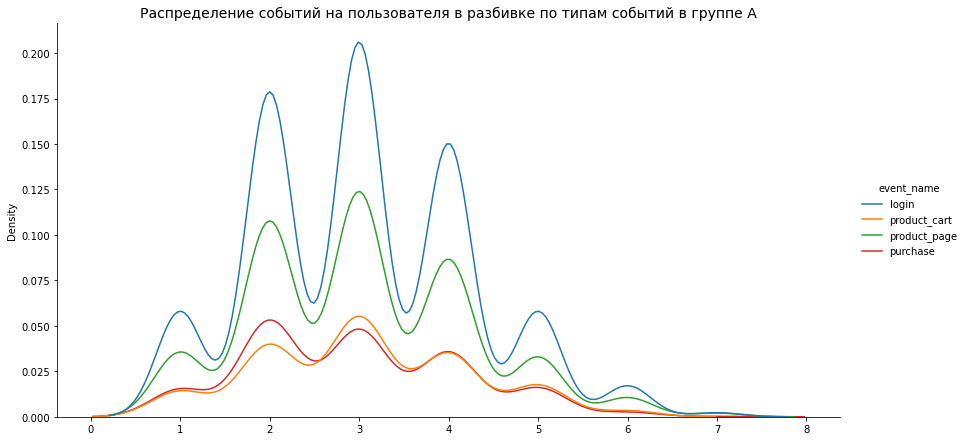

In [116]:
sns.displot(data=events_by_name_a,
            kind="kde",
            height=6,
            #kde = True,
            aspect=2,
            #hue="products",
            #multiple="stack",
            #fill = True
           )

plt.title('Распределение событий на пользователя в разбивке по типам событий в группе А', fontsize=14)
plt.show()

Из графика видим, что в группе А больше всего событий login, события просмотра корзины и покупки часто накладываются друг на друга.

In [117]:
events_by_name_b = pd.pivot_table(test_data_b, 
               values='event_dt', 
               index='user_id', 
               columns='event_name', 
               aggfunc='count')
events_by_name_b.head()

event_name        login  product_cart  product_page  purchase
user_id                                                      
005E096DBD379BCF   2.00           NaN           NaN      2.00
015D1E3BB893349D   3.00           NaN          3.00       NaN
015FF3EC72C1F4F6   1.00           NaN          1.00       NaN
01B0B891CA513468   4.00          4.00          4.00       NaN
01C17F099908DA14   5.00           NaN           NaN       NaN

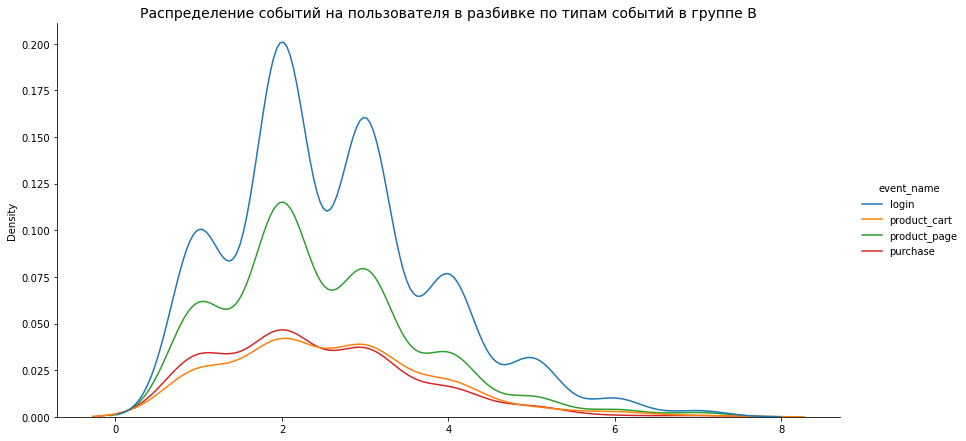

In [118]:
sns.displot(data=events_by_name_b,
            kind="kde",
            height=6,
            aspect=2,
            #multiple="stack",
            #fill = True
           )

plt.title('Распределение событий на пользователя в разбивке по типам событий в группе B', fontsize=14)
plt.show()

Отсюда тоже видим, каких событий больше в группе В. Также видим наложение оплат и просмотра корзин.

### Распределение событий в выборках по дням

Рассмотрим, как число событий в выборках распределено по дням:

In [119]:
test_data.head()

user_id group            event_dt    event_name  details  \
0  D1ABA3E2887B6A73     A 2020-12-07 14:43:27      purchase    99.99   
2  D1ABA3E2887B6A73     A 2020-12-07 14:43:29  product_cart      NaN   
4  D1ABA3E2887B6A73     A 2020-12-07 14:43:27  product_page      NaN   
6  D1ABA3E2887B6A73     A 2020-12-07 14:43:27         login      NaN   
8  A7A3664BD6242119     A 2020-12-20 15:46:06  product_page      NaN   

  first_date region  device         horizon  
0 2020-12-07     EU      PC 0 days 14:43:27  
2 2020-12-07     EU      PC 0 days 14:43:29  
4 2020-12-07     EU      PC 0 days 14:43:27  
6 2020-12-07     EU      PC 0 days 14:43:27  
8 2020-12-20     EU  iPhone 0 days 15:46:06

Добавим в датасет колонку с датой (днем) без времени:

In [120]:
test_data['event_date'] = pd.to_datetime(test_data['event_dt'], format='%Y-%m-%dT').dt.date

In [121]:
#del test_data_full['event_dt']

In [122]:
test_data_by_date = pd.pivot_table(test_data, 
               values='event_name', 
               index='event_date', 
               columns='group', 
               aggfunc='count')
test_data_by_date

group          A    B
event_date           
2020-12-07   234  290
2020-12-08   267  183
2020-12-09   296  273
2020-12-10   265  196
2020-12-11   282  122
2020-12-12   282  154
2020-12-13   253  115
2020-12-14   823  217
2020-12-15   834  174
2020-12-16   810  291
2020-12-17   927  209
2020-12-18   976  213
2020-12-19  1180  228
2020-12-20  1193  249
2020-12-21  1537  317
2020-12-22  1004  133
2020-12-23   748  119
2020-12-24   631   92
2020-12-25   478   62
2020-12-26   414   47
2020-12-27   411   57
2020-12-28   270   42
2020-12-29   225   31

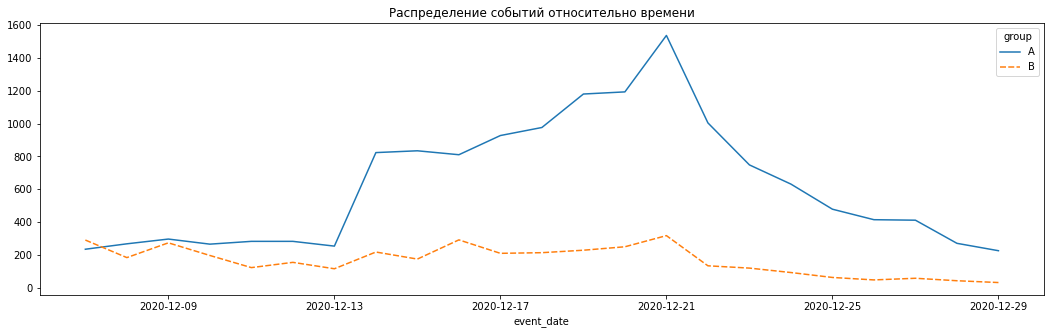

In [123]:
plt.figure(figsize=(18,5))
sns.lineplot(data=test_data_by_date)
plt.title("Распределение событий относительно времени")
plt.show()

В группе А происходит больше событий, чем в группе В. После 13 декабря растет число событий в группе А, достигая своего пика 21 декабря, и дальше планомерно снижается. В группе В нет таких резких скачков роста количества событий.

Основные различия между группами отражены. По динамике группы совсем не похожи.

In [124]:
event_data_by_date = pd.pivot_table(test_data, 
                                   values='user_id', 
                                   index='event_date', 
                                   columns='event_name', 
                                   aggfunc='nunique')

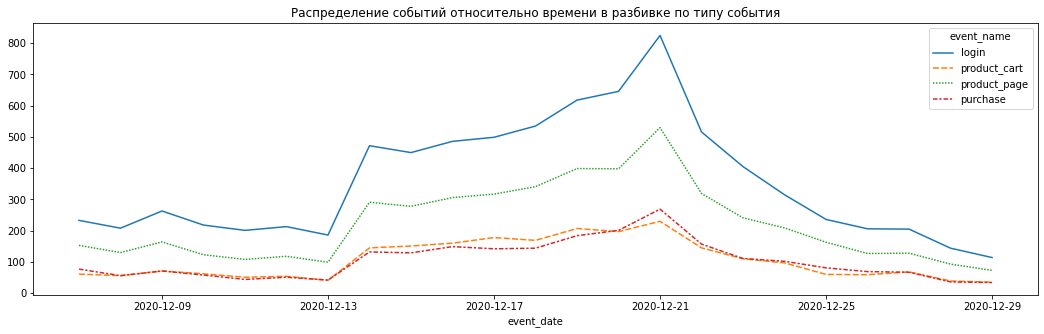

In [125]:
plt.figure(figsize=(18,5))
sns.lineplot(data=event_data_by_date)
plt.title("Распределение событий относительно времени в разбивке по типу события")
plt.show()

Из графика видно, что больше всего событий типа login, далее следует product_page. События просмотра корзины (product_cart) и оплаты покупки (purchase) судя по графику иногда наслаиваются друг на друга. В некоторые моменты времени больше трансакций по оплате, чем кликов в корзину.

In [126]:
purchase_by_date = pd.pivot_table(test_data, 
               values='details', 
               index='event_date', 
               columns='group', 
               aggfunc='sum')
purchase_by_date

group             A        B
event_date                  
2020-12-07   744.70   639.53
2020-12-08   734.70   344.74
2020-12-09 1,324.57   354.72
2020-12-10 1,189.62   609.80
2020-12-11   959.67    69.89
2020-12-12   729.71   309.78
2020-12-13   254.75   279.83
2020-12-14 2,813.96   249.72
2020-12-15 2,368.91 1,209.80
2020-12-16 2,508.87 1,364.64
2020-12-17 2,038.80   324.78
2020-12-18 2,128.80   234.76
2020-12-19 3,533.39   149.77
2020-12-20 3,793.29   769.70
2020-12-21 6,167.77 2,194.54
2020-12-22 4,158.66   224.77
2020-12-23 1,329.06   194.83
2020-12-24 2,699.09    64.89
2020-12-25 1,994.26   134.93
2020-12-26 1,049.35    19.96
2020-12-27 1,099.42 1,134.91
2020-12-28   484.66    14.98
2020-12-29   254.70    19.96

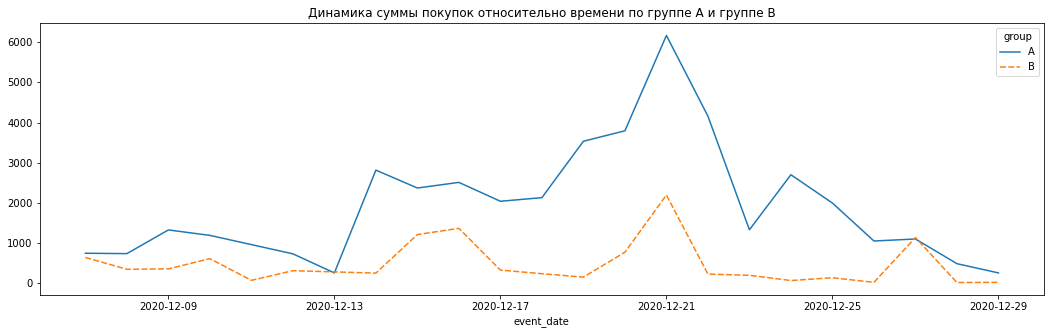

In [127]:
plt.figure(figsize=(18,5))
sns.lineplot(data=purchase_by_date)
plt.title("Динамика суммы покупок относительно времени по группе А и группе В")
plt.show()

Видим, что тренд динамики суммы покупок похож на выявленные выше тренды распределения событий во времени. Сумма покупок выше в группе А. Пик суммы покупок приходится на 21 декабряю

### Среднедневная посещаемость

Рассмотрим среднедневную посещаемость:

In [128]:
traffic = pd.pivot_table(test_data, 
               values='user_id', 
               index='event_date', 
               #columns='group', 
               aggfunc='nunique') #считаем кол-во уникальных пользователей в день
traffic

user_id
event_date         
2020-12-07      238
2020-12-08      209
2020-12-09      263
2020-12-10      218
2020-12-11      201
2020-12-12      213
2020-12-13      186
2020-12-14      472
2020-12-15      450
2020-12-16      486
2020-12-17      499
2020-12-18      535
2020-12-19      618
2020-12-20      646
2020-12-21      825
2020-12-22      516
2020-12-23      405
2020-12-24      315
2020-12-25      236
2020-12-26      206
2020-12-27      205
2020-12-28      144
2020-12-29      114

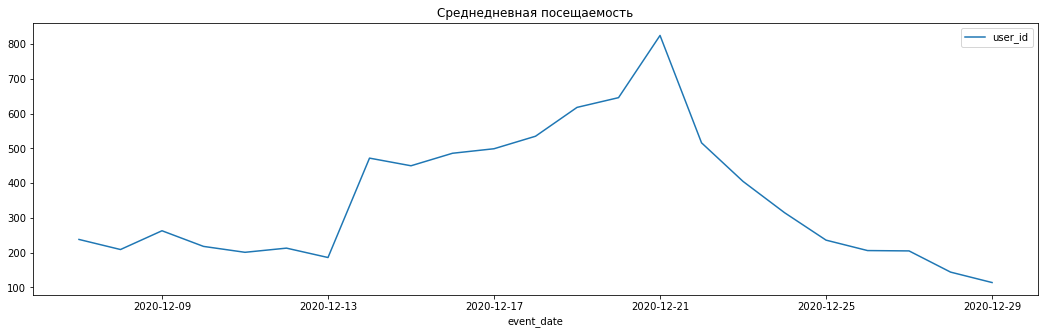

In [129]:
plt.figure(figsize=(18,5))
sns.lineplot(data=traffic)
plt.title("Среднедневная посещаемость")
plt.show()

In [130]:
test_data_by_date.mean()

group
A   623.48
B   165.83
dtype: float64

Посещаемость за весь период в среднем равна 356 человек в день.

### Изменения конверсии в воронке в выборках на разных этапах

Рассмотрим, как меняется конверсия в воронке в выборках на разных этапах.

In [131]:
test_data.head()

user_id group            event_dt    event_name  details  \
0  D1ABA3E2887B6A73     A 2020-12-07 14:43:27      purchase    99.99   
2  D1ABA3E2887B6A73     A 2020-12-07 14:43:29  product_cart      NaN   
4  D1ABA3E2887B6A73     A 2020-12-07 14:43:27  product_page      NaN   
6  D1ABA3E2887B6A73     A 2020-12-07 14:43:27         login      NaN   
8  A7A3664BD6242119     A 2020-12-20 15:46:06  product_page      NaN   

  first_date region  device         horizon  event_date  
0 2020-12-07     EU      PC 0 days 14:43:27  2020-12-07  
2 2020-12-07     EU      PC 0 days 14:43:29  2020-12-07  
4 2020-12-07     EU      PC 0 days 14:43:27  2020-12-07  
6 2020-12-07     EU      PC 0 days 14:43:27  2020-12-07  
8 2020-12-20     EU  iPhone 0 days 15:46:06  2020-12-20

In [132]:
test_data_funnel = pd.pivot_table(test_data,
                                  index='event_name', 
                                  columns='group',
                                  aggfunc={'user_id': 'nunique'}) # считаем уникальных пользователей
test_data_funnel.columns = ['A', 'B']
#test_data_funnel = test_data_funnel.sort_values(by='A', ascending=False)
test_data_funnel

A    B
event_name             
login         2082  705
product_cart   631  195
product_page  1360  397
purchase       652  198

В таблице выше этапы воронки идут в неправильном порядке, поэтому переиндексируем таблицу:

In [133]:
test_data_funnel.index

Index(['login', 'product_cart', 'product_page', 'purchase'], dtype='object', name='event_name')

In [134]:
new_index = ['login', 'product_page', 'product_cart', 'purchase']

In [135]:
test_data_funnel = test_data_funnel.reindex(new_index)
test_data_funnel

A    B
event_name             
login         2082  705
product_page  1360  397
product_cart   631  195
purchase       652  198

Теперь этапы выводятся так, как нам нужно.

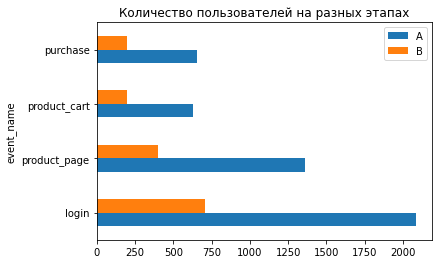

In [136]:
test_data_funnel.plot(kind='barh')
plt.title("Количество пользователей на разных этапах")
plt.show()

События происходят в следующем порядке:

* login - экран авторизации;
* product_page - экран продукта;
* product_cart - просмотр корзины продукта;
* purchase - экран оплаты.

In [137]:
test_data_funnel = test_data_funnel.reset_index()

In [138]:
test_data_funnel['total'] = test_data_funnel['A'] + test_data_funnel['B']
test_data_funnel['share'] = test_data_funnel['total'] / test_data_funnel['total'][0] * 100
test_data_funnel['share_A'] = test_data_funnel['A'] / test_data_funnel['A'][0] * 100
test_data_funnel['share_B'] = test_data_funnel['B'] / test_data_funnel['B'][0] * 100

In [139]:
test_data_funnel

event_name     A    B  total  share  share_A  share_B
0         login  2082  705   2787 100.00   100.00   100.00
1  product_page  1360  397   1757  63.04    65.32    56.31
2  product_cart   631  195    826  29.64    30.31    27.66
3      purchase   652  198    850  30.50    31.32    28.09

In [140]:
fig = go.Figure(go.Funnel(
    y = test_data_funnel['event_name'],
    x = test_data_funnel['total'],
    textinfo = "value+percent initial")
)

fig.update_layout(
    title={
        'text': "Воронка продаж",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

### Этапы воронки

Построим воронку продаж в разбивке по группам А/В.

In [141]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = test_data_funnel['event_name'],
    x = test_data_funnel['A'],
    textinfo = "value+percent initial"))         

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = test_data_funnel['event_name'],
    x = test_data_funnel['B'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
    title={
        'text': "Воронка продаж в разбивке по группам A/B",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Из воронки видно, какой % пользователей из каждой группы перешел на следующий этап. Происходили изменения конверсии в воронке в выборках на разных этапах. События происходят в следующем порядке: (1) **login** - экран авторизации; **product_page** - экран продукта; **product_cart** - просмотр корзины продукта; **purchase** - экран оплаты. 

* В группе А на этапе (1) 100% пользователей, на этапе (2) - 65% пользователей, на этапе (3) - 30%, (4) - 31% (!). 

* В группе В конверсия ниже, из 100% залогинившихся пользователей только 56% переходят на станицу продукта, далее по 28% идет на 3 и 4 этап.

### Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию

* Больше всего пользователей теряется на первом этапе: 35% в группе А и 44% в группе В. 
* В группе А на этап (4) "оплата" вышел бОльший процент, чем на предыдущий этап корзины. То есть пользователи покупают, минуя корзину.

## Результаты A/B-тестирования

### Результаты A/B-тестирования

Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
   - конверсии в просмотр карточек товаров — событие `product_page`,
   - просмотры корзины — `product_cart`,
   - покупки — `purchase`.

In [142]:
test_data_funnel = test_data_funnel.set_index('event_name')
#del test_data_funnel['index']

In [143]:
funnel = test_data_funnel[['A', 'B']]

In [144]:
funnel

A    B
event_name             
login         2082  705
product_page  1360  397
product_cart   631  195
purchase       652  198

In [145]:
funnel.loc['purchase', 'A']

652

In [146]:
trials = test_data.groupby('group').agg({'user_id': 'nunique'})
trials

user_id
group         
A         2903
B         2196

In [147]:
trials1 = trials['user_id'][0]  #размер группы А
trials1

2903

In [148]:
trials2 = trials['user_id'][1] #размер группы В
trials2

2196

Будем проверять гипотезу о равенстве долей.

Сформулируем гипотезы:

 * **H0:** нет статистически значимой разницы между долями при сравнении выборок групп А и В по событию С, где С - один из  вариантов -  `product_page`, `product_cart`, `purchase`, т.е. одна и та же доля пользователей совершает одно из этих событий
 * **H1:** между указанными выше долями есть статистически значимая разница, - доли пользователей, совершающих то или иное событие, отличаются

### Проверка статистической разницы долей z-критерием

In [149]:
alpha = 0.05

In [150]:
unique_events = ['login', 'product_page', 'product_cart', 'purchase']

In [151]:
p_values = []
for event in unique_events:
    successes1 = funnel.loc[event, 'A'] # доля по группе А по событию event
    successes2 = funnel.loc[event, 'B'] # доля по группе B по событию event
    trials1 = trials['user_id'][0]  #размер группы А
    trials2 = trials['user_id'][1] #размер группы В
           
    p = check_hypothesis(successes1,
                         successes2,
                         trials1,
                         trials2)
       
    p_values += [[event, p]]
        
p_values = pd.DataFrame(p_values, columns = ['event', 'p_value'])
p_values['result'] = p_values['p_value'].apply(final_result)

In [152]:
p_values

event  p_value  \
0         login     0.00   
1  product_page     0.00   
2  product_cart     0.00   
3      purchase     0.00   

                                                                          result  
0  Отвергаем нулевую гипотезу - между долями есть статистически значимая разница  
1  Отвергаем нулевую гипотезу - между долями есть статистически значимая разница  
2  Отвергаем нулевую гипотезу - между долями есть статистически значимая разница  
3  Отвергаем нулевую гипотезу - между долями есть статистически значимая разница

**Вывод**: По всем событиям воронки отвергаем нулевую гипотезу, то есть между долями есть статистическая значимая разница. 

Ожидаемым эффектом было улучшение конверсии в группе B не менее, чем на 10%. Но фактически значения конверсии ухудшились. 

In [153]:
final_funnel = test_data_funnel[['A', 'B', 'share_A', 'share_B']]
final_funnel

A    B  share_A  share_B
event_name                               
login         2082  705   100.00   100.00
product_page  1360  397    65.32    56.31
product_cart   631  195    30.31    27.66
purchase       652  198    31.32    28.09

Из таблицы выше видим снижение конверсии на разных этапах воронки.

## Выводы

### Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования

Исследовательский анализ данных показал, что:

* Согласно анализу **количества событий на пользователя**, в группе А пользователи совершали в среднем 7 событий, а в группе В - 5 событий.

* Распределение **событий в выборках по дням** свидетельствует о том, что в группе А происходит больше событий, чем в группе В. После 13 декабря растет число событий в группе А, достигая своего пика 21 декабря, и дальше планомерно снижается. В группе В нет таких резких скачков роста количества событий.

* Происходили **изменения конверсии в воронке** в выборках на разных этапах. События происходят в следующем порядке: (1) login - экран авторизации; product_page - экран продукта; product_cart - просмотр корзины продукта; purchase - экран оплаты. В группе А на этапе (1) 100% пользователей, на этапе (2) - 65% пользователей, на этапе (3) - 30%, (4) - 30%. В группе В конверсия ниже, из 100% залогинившихся пользователей только 53% переходят на станицу продукта, далее 27% добавляют товар в корзину и 26% делают заказ.

Результаты А/В тестирования показали, что по всем событиям воронки **есть статистически значимая разница между конверсиями** в группах. Но ожидаемый результат не был достигнут, так как показатели конверсии не улучшились, а ухудшились.

### Общее заключение о корректности проведения теста

По итогам проверки корректности теста было отмечено, что:
- данные по тесту `recommender_system_test` присутствуют в датасетах, есть значения по группам А и В.
- **сроки проведения теста** с 7 декабря по 4 апреля 2021 г. Действия пользователей зафиксированы с 7 декабря 2020 г. по 30 декабря 2020 г. В датасете есть данные о новых пользователях до 23 декабря 2020г., а согласно ТЗ сбор сведений о новых пользователей должен заканчиваться 21 декабря. В декабре 2020 г. начали проводится два маркетинговых мероприятия - Christmas&New Year Promo, CIS New Year Gift Lottery. Их проведение совпадает с нашим тестом!

- при **анализе аудитории теста** были найдены пересечения с конкурирующим тестом (1602 пользователя), которые были удалены из датасета. Согласно ТЗ, аудитория: 15% новых пользователей из региона EU. Анализ показал, что их **11.21%** после очистки пересекающихся значений. Также в таблице участников теста есть небольшое количество пользователей из других регионов.

Далее необходимо выяснить, можем ли мы доверять результатам этого теста с учетом всех обнаруженных проблем.

### Доверие результатам теста

<div class="alert alert-info">
 

|№|Показатель|Требования ТЗ|Итоги проверки корректности|
|:-----|:-----|:-----|:-----|
|0| Название теста| recommender_system_test| +|
|1| группы| А — контрольная, B — новая платёжная воронка| +|
|2|дата запуска| 2020-12-07|+|
|3|дата остановки набора новых пользователей| 2020-12-21|Фактически в данных было - **2020-12-23**, данные были обрезаны|
|4|дата остановки| 2021-01-04|Здесь данные были до **2020-12-30**, плюс произошло наслоение на маркетинговые акции 25-30 декабря|
|5|аудитория| 15% новых пользователей из региона EU|В итоге получилось **11.21%**, z-test показал, что разница статистически значима|
|6|назначение теста| тестирование изменений, связанных с внедрением улучшенной рекомендательной системы|+|
|7|ожидаемое количество участников теста| 6000|В начальной таблице было **6701** участников теста recommender_system_test, после обрезки совпадений с конкурирующим тестом осталось меньше - **5099**|
|8|ожидаемый эффект| за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%|Для соответствия этому условию было удалено **650 строк** с действиями пользователей, которые не укладывались в 14-дневный лайфтайм|

</div>

* В итоге размер выборки получился **5099** человек. Длительность теста с 7 декабря по 30 декабря (**23 дня**).  
* Минимальный эффект, который хотим обнаружить, равен **10%** (изменение конверсии).

* Мы не знаем уровень **базовой конверсии** до проведения теста (**нет данных**).
* Также нет данных о средней дневной **посещаемости** до проведения теста. Во время теста она равна 356 пользователей в день (тех, которые участвовали в тесте).

### Проверка расчета размера выборки

Используем  [Калькулятор расчёта размера выборки](https://www.evanmiller.org/ab-testing/sample-size.html).
Minimum baseline effect = 10% (относительное изменение метрик конверсии).

<image src="https://ibb.co/mS2YPjK" alt="Описание картинки">

<img src=https://i.postimg.cc/QtPMyDFW/Untitled.jpg><br>


Если предположить, что уровень базовой конверсии был равен 20%, то для проведения теста нужна выборка 6347 пользователей. А у нас было 5099.

### Проверка длительности теста

Принимая решение о длительности теста, учитывают циклические изменения трафика (ежедневные, еженедельные, ежемесячные) и время, за которое покупатель принимает решение о покупке.

Используем  [калькулятор](https://vwo.com/tools/ab-test-duration-calculator/).
Minimum baseline effect = 10% (относительное изменение метрик конверсии).

<img src=https://i.postimg.cc/pLVVBCCj/image.jpg><br>

При уровене базовой конверсии 20% нам была бы нужна длительность теста в 36 дней, а наш тест шел 23 дня.

В итоге тест шел 23 дня вместо 28 дней, было 5099 пользователей вместо 6000. Скорее всего, доверять результатам в полной мере нельзя.